In [2]:
from parameter_object import parameterClass
%pylab inline
#Imports .mdf files for providing ground-truth data.
from sklearn.cross_validation import ShuffleSplit
import numpy as np
#sys.path.append('resources')
#sys.path.append('final_software')
import v2_functions as v2
reload(v2)
from scipy.ndimage import measurements, center_of_mass,filters
from sklearn.ensemble import ExtraTreesRegressor
import time
import tifffile2 as tif_fn
import csv
import cPickle as pickle

`%matplotlib` prevents importing * from pylab and numpy
tifffile2.py:253: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


Populating the interactive namespace from numpy and matplotlib


In [11]:

#This is a class and function which takes over the print output in the absence of the gui.
class intObject():
    def __init__(self):
        self.pa = None
    def report_progress(self,string):
        d=0
        print(string)
        
    
#Here we choose which of our experiments to run.
for exp in [1]:
    

    
    if exp == 1:
        path = '/Users/dwaithe/Documents/collaborators/hailstonem/4d_examples'
        tif_out_path = '/Users/dwaithe/Documents/collaborators/hailstonem/out'
    
    #This is where we have the parameter sets.
    for num_of_train in [8]:
        #Number of times to repeat.
        for bc in range(0,1):
            int_obj = intObject()
            
            
            ####If we have cross-validation.
            #if exp ==1:
            #    ss = ShuffleSplit(30, n_iter=1, test_size=15, train_size=num_of_train)
            #for train_index, test_index in ss:
                 #print("%s %s" % (train_index, test_index))
            ####
            ###Remove the following in favour of the above cross-validation
            train_index = [0]
            test_index = [0]
            ###
    
            temp_index = list(train_index)
            #temp_index.extend(list(test_index))
            #test_index = temp_index
            print train_index, test_index
            par_obj = parameterClass()
            int_obj = intObject()
            par_obj.gt_sum = {}
            par_obj.gt_dense ={}
            par_obj.f_matrix =[]
            par_obj.o_patches=[]
            par_obj.gt_sum = {}
            par_obj.gt_dense ={}
            par_obj.gt_file_array = []
            par_obj.frames_2_load = {}
            
            
            ####May want to change these of course for the hessian and maxima finding.
            #par_obj.min_distance
            #par_obj.abs_thr
            #par_obj.rel_thr
            ####
            
            par_obj.feature_type = 'basic'

            if exp == 1:
                
                nstr = [0]*1#Number of files to upload
            
            
            datasets=['dense_arr','feat_arr','double_feat_arr','pred_arr','sum_pred','maxi_arr','pts','roi_stk_x','roi_stk_y','roi_stkint_x','roi_stkint_y']
            par_obj.data_store={}
            
            for dataname in datasets:
                par_obj.data_store[dataname]={}
            
            
            #We initalize each of our images in our experiments.
            for i in range(0,nstr.__len__()):
                n = str(i).zfill(3)
                if exp == 1:
                    par_obj.ch_active =[0,1]
                    par_obj.sigma =  [float(13),float(12),float(12)];
                    if i == 0:

                        file_str = path+'/20150506_JupGFP_HisRFP_60x_12h_L2(Partial Open).tif'
                        ROI_str = path+'/dots_to_save.quantiROI'
                        
                par_obj.file_array.append(file_str)
                #par_obj.gt_file_array.append(gt_file_str)

            #Gets the dimensional information from the first file.
            #Assumes they are all the same. May not be true, but Martin you changed the data_structure :-).
            v2.import_data_fn(par_obj,[par_obj.file_array[0]])
            par_obj.time_pt_list = np.arange(0,par_obj.total_time_pt)
            par_obj.max_file = nstr.__len__()
            par_obj.initiate_data_store()
            
            
            print('Calculating features')
            
            #Import ROI for file.
            ROI_file = pickle.load( open(ROI_str,"rb"))
            par_obj.saved_dots = ROI_file['dots']
            par_obj.saved_ROI = ROI_file['rect']
            
            
            #Need to update this with the imported saved points.
            
            
            
            for b in train_index:

                t1 = time.time()
                
                
                t2 = time.time()
                print "Image_id\t",b, 'time taken: ',t2-t1
                
                
                
                #Need to initialise are region for each image, which encompasses the whole plane.
                for i in range(0,par_obj.saved_ROI.__len__()):
                    rects = par_obj.saved_ROI[i]
                    zslice = par_obj.saved_ROI[i][0]
                    tpt = par_obj.saved_ROI[i][5]
                    imno = par_obj.saved_ROI[i][6]
                    v2.import_data_fn(par_obj,[par_obj.file_array[b]])
                    par_obj.height = par_obj.ori_height
                    par_obj.width = par_obj.ori_width
                    
                    #Load in image data
                    v2.im_pred_inline_fn_new(par_obj, int_obj,[zslice],[tpt],[imno],threaded=False)
                    #Create the input kernel 3-D map.
                    v2.update_com_fn(par_obj,tpt,zslice,imno)
                    #Take the annotations and the features.
                v2.update_training_samples_fn_new_only(par_obj,int_obj,rects)
                    
                    



            ##### Trains the forest. #####

            par_obj.RF ={}
            par_obj.RF[0] = ExtraTreesRegressor(par_obj.num_of_tree, max_depth=par_obj.max_depth, min_samples_split=par_obj.min_samples_split, min_samples_leaf=par_obj.min_samples_leaf, max_features=par_obj.max_features, bootstrap=True, n_jobs=-1)


            par_obj.pred_arr = {}
            par_obj.sum_pred = {}


            #Fits the data.
            t3 = time.time()
            par_obj.RF[0].fit(par_obj.f_matrix, par_obj.o_patches)
            rf_score = par_obj.RF[0].score(par_obj.f_matrix, par_obj.o_patches)
            t4 = time.time()
            time_to_train = t4-t3
            print 'Time to train',time_to_train
            

            ##### Evaluation of images. ######
            
            par_obj.final_prediction = {}
            time_taken_to_calc_feat = []
            time_taken_to_eval_trees = []
            print 'Calculating features for evaluation'
            par_obj.the_score = {}
            for b in test_index:
                par_obj.sum_pred ={}

                t1 = time.time()
                file_str = par_obj.file_array[b]
                #We import the image.
                v2.import_data_fn(par_obj,[file_str])
                #Encase they are different.
                par_obj.height = par_obj.ori_height
                par_obj.width = par_obj.ori_width
                zslice_list = np.arange(0,par_obj.max_zslices)
                time_list = np.arange(0,par_obj.total_time_pt)
                
                
                #Read in the frames.
                v2.im_pred_inline_fn_new(par_obj, int_obj,zslice_list,time_list,[b],threaded=True)
                #Evalute the forest for each slice.
                v2.evaluate_forest_new(par_obj,int_obj,False,0,zslice_list,time_list,[b],threaded=False,b=b,arr='feat_arr')
                t2 = time.time()
                time_taken_to_calc_feat.append(t2-t1)
                print 'Image_id: ',b,' time taken to calc features: ',time_taken_to_calc_feat[-1]
                par_obj.frames_2_load = zslice_list
                
                
                
                
                #Now we calculate the maxima locations.
                for fileno in range(par_obj.max_file):
                    for tpt in par_obj.time_pt_list:
                        v2.count_maxima(par_obj,tpt,fileno)
                        
                
               
                par_obj.final_prediction[b] = 0
                for c in par_obj.sum_pred:
                    par_obj.final_prediction[b] += par_obj.sum_pred[c]
                
                #Will export a particular timepoint to visualise.
                with tif_fn.TiffWriter(tif_out_path+'/exp_'+str(exp)+'_image-dense_0'+str(b)+'.tif', bigtiff=True) as tif:
                    for zslice in zslice_list:
                        tif.save(np.array(par_obj.data_store['pred_arr'][b][0][zslice]), compress=0)
                
                
            
            """
            csvPath = "/Users/dwaithe/Documents/collaborators/WaitheD/simulated Data/drosophilaBrain/large_dots/";
            output = '\tPath of data:\t',path,'\time to train\t',time_to_train,'\tnumber of training images.\t',num_of_train,'\tthe score\t',rf_score
            with open(csvPath+'outputDataLastTrainFIN.csv', 'a') as csvfile:
                spamwriter = csv.writer(csvfile,  dialect='excel')
                spamwriter.writerow(output)
            per_err =[]
            for i,item in enumerate(test_index):
                test= False
                for c in train_index:
                    if item  == c:
                        test = True;
                per_err.append((1-(abs(par_obj.gt_dense[item] - par_obj.final_prediction[item])/par_obj.gt_dense[item]))*100)
                #output =  "\timage_id\t",item,"\ttime to process\t",time_taken_to_calc_feat[i],"\ttime to evaluate\t",time_taken_to_eval_trees[i],"\ttest\t",test,"\tgt_dense\t",par_obj.gt_dense[item],"\tfinal_predicion\t",par_obj.final_prediction[item],"\tper_err\t",per_err,"\tthe_score\t",par_obj.the_score[item]
            output = "\toutput\t",np.average(per_err)
            print output
            with open(csvPath+'outputDataLastTrainFIN.csv', 'a') as csvfile:
                    spamwriter = csv.writer(csvfile,  dialect='excel')
                    spamwriter.writerow(output)"""

[0] [0]
0
tiff resolution not recognised
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
Calculating features
Image_id	0 time taken:  0.0
0
tiff resolution not recognised
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
version1
[0]
[0]
[0]
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
Calculating Features for Z:1 Timepoint: 1 File: 1
Using template matching to generate C-O-M representation
0
tiff resolution not recognised
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
version1
[0]
[0]
[4]
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
Calculating Features for Z:5 Timepoint: 1 File: 1
Using template matching to generate C-O-M representation
(4, 56, 108, 108, 69, 0, 0)
7276
Time to train 0.345936059952
Calculating features for evaluation
0
tiff resolution not recognised
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
version1
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
Calculating Features for Timepoint

In [202]:
par_obj.data_store['pred_arr'][b][0][zslice]

KeyError: 0

In [8]:
par_obj.frames_2_load = zslice_list
for fileno in range(par_obj.max_file):
            for tpt in par_obj.time_pt_list:
                v2.count_maxima(par_obj,tpt,fileno)

In [10]:
par_obj.data_store['pts'][fileno][0]

array([[ 90, 105,   4],
       [103, 141,   0],
       [122,  72,   4],
       [128,  70,   2],
       [128,  72,   1],
       [135,  72,   4],
       [150,  87,   4],
       [161, 101,   4]])

In [130]:
par_obj.ori_width

256

0
tiff resolution not recognised
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
version1
here
[1]
[1]
[1, 2, 3, 4]
hereA
hereB
tiff (10, 5, 256, 256, 2)
tiff2 (256, 256, 2)
shapeofIMRGB (256, 256, 2)
Calculating Features for Z:2 Timepoint: 2 File: 2
[[[ 0.03296703  0.04249084]
  [ 0.03516484  0.04297924]
  [ 0.03565324  0.04371184]
  ..., 
  [ 0.03369964  0.04102564]
  [ 0.03321123  0.04249084]
  [ 0.03589744  0.04053724]]

 [[ 0.03369964  0.03980464]
  [ 0.03492064  0.03956044]
  [ 0.03760684  0.04053724]
  ..., 
  [ 0.03736264  0.04151404]
  [ 0.03540904  0.04126984]
  [ 0.03467644  0.04297924]]

 [[ 0.03076923  0.03931624]
  [ 0.03492064  0.04175824]
  [ 0.03540904  0.03980464]
  ..., 
  [ 0.03785104  0.04322344]
  [ 0.03321123  0.03931624]
  [ 0.03956044  0.04126984]]

 ..., 
 [[ 0.03369964  0.03785104]
  [ 0.03736264  0.14578755]
  [ 0.03321123  0.04126984]
  ..., 
  [ 0.03467644  0.04175824]
  [ 0.03492064  0.04297924]
  [ 0.03492064  0.03809524]]

 [[ 0.03492064  0.04200244]
  [ 

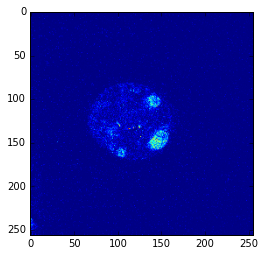

In [168]:
import v2_functions as v2
reload(v2)
par_obj.time_pt_list = [1,2,3,4,5,6,7,8,9,10]
par_obj.max_file =2
par_obj.initiate_data_store()
v2.import_data_fn(par_obj,[file_str])
imRGB = v2.im_pred_inline_fn_new(par_obj, int_obj,[1,2,3,4],[1],[1],threaded=False)
print imRGB
imRGB = v2.get_tiff_slice(par_obj,[0],[0],range(0,par_obj.ori_width,par_obj.resize_factor),range(0,par_obj.ori_height,par_obj.resize_factor),range(par_obj.numCH))
imshow(imRGB[:,:,0])     

In [163]:
par_obj.ch_active

[]